Imports

In [1]:
# --- MNIST and CNN Experiments ---
# Section 3.1 (MLP) and 3.2 (CNN)
# Author: <Your Name>
# Deep Learning Assignment (PyTorch)

import time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms, models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm
import random, os


Configuration and Device Setup

In [2]:
# Reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Hyperparameters
BATCH = 128
EPOCHS_MLP = 10
EPOCHS_CNN = 6
SUBSET_TRAIN_SIZE = None  # set to e.g. 10000 if compute-limited
MNIST_ROOT = "./data"


Using device: cuda


Load and Prepare Data

In [3]:
transform_mnist = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_ds = datasets.MNIST(MNIST_ROOT, train=True, download=True, transform=transform_mnist)
test_ds  = datasets.MNIST(MNIST_ROOT, train=False, download=True, transform=transform_mnist)
fashion_test_ds = datasets.FashionMNIST(MNIST_ROOT, train=False, download=True, transform=transform_mnist)

# Optional smaller subset
if SUBSET_TRAIN_SIZE:
    labels = np.array(train_ds.targets)
    idx = []
    per_class = SUBSET_TRAIN_SIZE // 10
    for c in range(10):
        idx_c = np.where(labels == c)[0]
        idx.extend(np.random.choice(idx_c, per_class, replace=False))
    train_ds = Subset(train_ds, idx)

train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=BATCH)
fashion_loader = DataLoader(fashion_test_ds, batch_size=BATCH)


Define MLP Model

In [4]:
class MLP(nn.Module):
    def __init__(self, hidden1=30, hidden2=20):
        super().__init__()
        self.fc1 = nn.Linear(28*28, hidden1)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden2, 10)

    def forward(self, x, return_activations=False):
        x = x.view(x.size(0), -1)
        x = self.relu1(self.fc1(x))
        a20 = self.relu2(self.fc2(x))
        out = self.fc3(a20)
        return (out, a20) if return_activations else out


Train the MLP

In [5]:
def train_model(model, loader, epochs, lr=1e-3):
    model.to(device)
    opt = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()

    for ep in range(epochs):
        model.train()
        losses = []
        for x, y in tqdm(loader, desc=f"Epoch {ep+1}/{epochs}", leave=False):
            x, y = x.to(device), y.to(device)
            opt.zero_grad()
            out = model(x)
            loss = loss_fn(out, y)
            loss.backward()
            opt.step()
            losses.append(loss.item())
        print(f"Epoch {ep+1}: Loss = {np.mean(losses):.4f}")
    return model

mlp = MLP()
print("Training MLP...")
mlp = train_model(mlp, train_loader, EPOCHS_MLP)


Training MLP...


Epoch 1: Loss = 0.4873


Epoch 2: Loss = 0.2236


Epoch 3: Loss = 0.1708


Epoch 4: Loss = 0.1427


Epoch 5: Loss = 0.1233


Epoch 6: Loss = 0.1105


Epoch 7: Loss = 0.1000


Epoch 8: Loss = 0.0926


Epoch 9: Loss = 0.0864


Epoch 10: Loss = 0.0807


Evaluate MLP

MLP Accuracy: 0.9673, F1: 0.9670


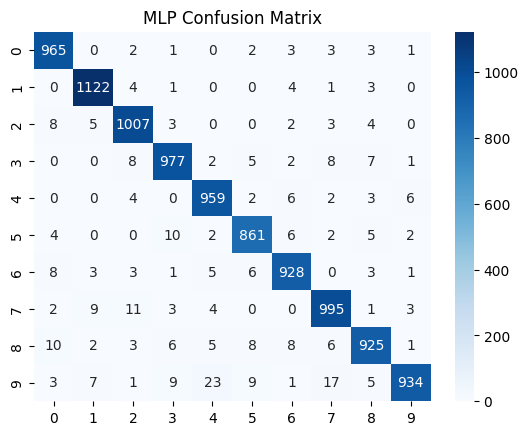

In [6]:
def evaluate_model(model, loader):
    model.eval()
    preds, ys = [], []
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            out = model(x)
            preds.append(out.argmax(1).cpu().numpy())
            ys.append(y.numpy())
    y_pred = np.hstack(preds)
    y_true = np.hstack(ys)
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')
    cm = confusion_matrix(y_true, y_pred)
    return acc, f1, cm, y_true, y_pred

acc_mlp, f1_mlp, cm_mlp, y_true_mlp, y_pred_mlp = evaluate_model(mlp, test_loader)
print(f"MLP Accuracy: {acc_mlp:.4f}, F1: {f1_mlp:.4f}")
sns.heatmap(cm_mlp, annot=True, fmt='d', cmap='Blues')
plt.title("MLP Confusion Matrix")
plt.show()


Visualize t-SNE (Trained vs Untrained + Fashion-MNIST)

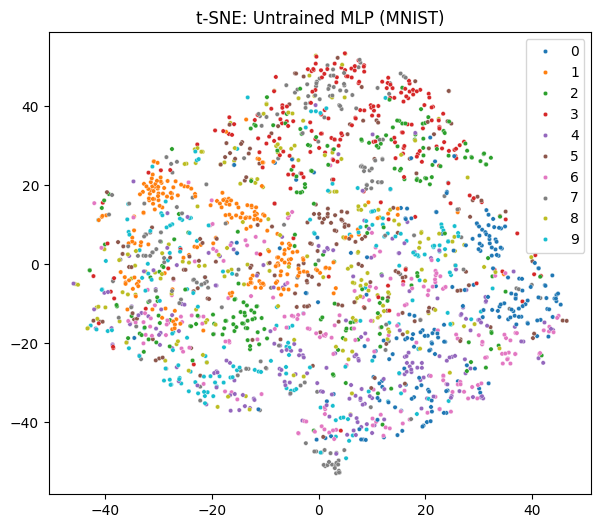

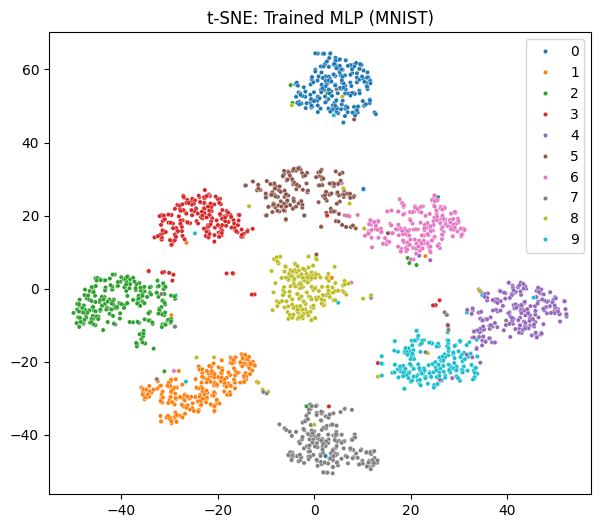

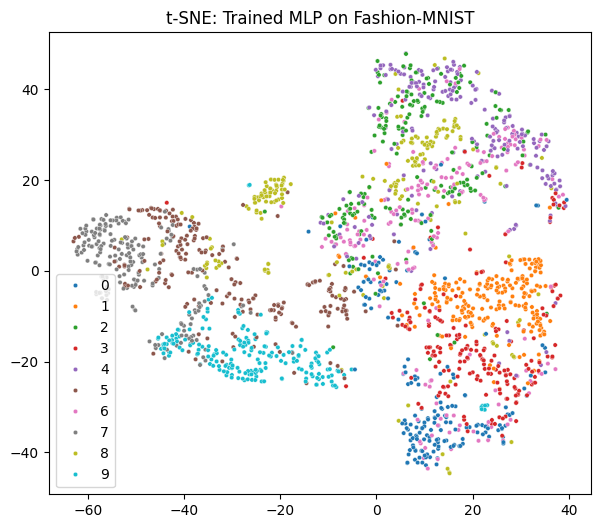

In [7]:
def collect_acts(model, loader):
    model.eval()
    acts, labels = [], []
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            _, a = model(x, return_activations=True)
            acts.append(a.cpu().numpy())
            labels.append(y.numpy())
    return np.vstack(acts), np.hstack(labels)

acts_trained, labels_test = collect_acts(mlp, test_loader)
acts_fashion, labels_fashion = collect_acts(mlp, fashion_loader)
acts_untrained, _ = collect_acts(MLP().to(device), test_loader)

def plot_tsne(acts, labels, title, sample_size=2000):
    if acts.shape[0] > sample_size:
        idx = np.random.choice(len(acts), sample_size, replace=False)
        acts, labels = acts[idx], labels[idx]
    ts = TSNE(n_components=2, random_state=seed, init="pca")
    z = ts.fit_transform(acts)
    plt.figure(figsize=(7,6))
    sns.scatterplot(x=z[:,0], y=z[:,1], hue=labels, palette="tab10", s=10)
    plt.title(title)
    plt.show()

plot_tsne(acts_untrained, labels_test, "t-SNE: Untrained MLP (MNIST)")
plot_tsne(acts_trained, labels_test, "t-SNE: Trained MLP (MNIST)")
plot_tsne(acts_fashion, labels_fashion, "t-SNE: Trained MLP on Fashion-MNIST")

Baseline Models (Logistic Regression & Random Forest)

In [12]:
def get_flattened(ds):
    loader = DataLoader(ds, batch_size=1024)
    X, y = [], []
    for imgs, labels in loader:
        X.append(imgs.view(imgs.size(0), -1).numpy())
        y.append(labels.numpy())
    return np.vstack(X), np.hstack(y)

X_train, y_train = get_flattened(train_ds)
X_test, y_test = get_flattened(test_ds)

print("Training Random Forest...")
rf_clf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
rf_clf.fit(X_train, y_train)
y_rf = rf_clf.predict(X_test)

print(f"RF Accuracy: {accuracy_score(y_test, y_rf):.4f}, F1: {f1_score(y_test, y_rf, average='macro'):.4f}")

print("Training Logistic Regression...")
lr_clf = LogisticRegression(max_iter=1000, solver='saga', n_jobs=-1)
lr_clf.fit(X_train, y_train)
y_lr = lr_clf.predict(X_test)

print(f"LR Accuracy: {accuracy_score(y_test, y_lr):.4f}, F1: {f1_score(y_test, y_lr, average='macro'):.4f}")


Training Random Forest...
RF Accuracy: 0.9703, F1: 0.9701
Training Logistic Regression...
LR Accuracy: 0.9255, F1: 0.9245


Visualize MLP Misclassifications

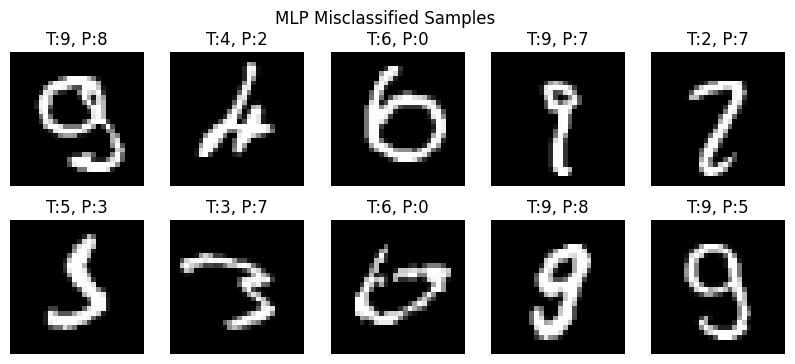

In [9]:
def show_misclassified(model, loader, num=10):
    model.eval()
    wrong_images, preds, actuals = [], [], []
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            out = model(x)
            pred = out.argmax(1).cpu()
            mask = pred != y
            if mask.sum() > 0:
                idxs = mask.nonzero(as_tuple=True)[0]
                for i in idxs:
                    wrong_images.append(x[i].cpu().squeeze().numpy())
                    preds.append(pred[i].item())
                    actuals.append(y[i].item())
                    if len(wrong_images) >= num:
                        break
            if len(wrong_images) >= num:
                break
    plt.figure(figsize=(10, 4))
    for i in range(num):
        plt.subplot(2, 5, i+1)
        plt.imshow(wrong_images[i], cmap='gray')
        plt.title(f"T:{actuals[i]}, P:{preds[i]}")
        plt.axis('off')
    plt.suptitle("MLP Misclassified Samples")
    plt.show()

show_misclassified(mlp, test_loader)


CNN Model

Training CNN...


Epoch 1: Loss = 0.2212


Epoch 2: Loss = 0.0698


Epoch 3: Loss = 0.0493


Epoch 4: Loss = 0.0331


Epoch 5: Loss = 0.0255


Epoch 6: Loss = 0.0194
CNN Accuracy: 0.9836, F1: 0.9835


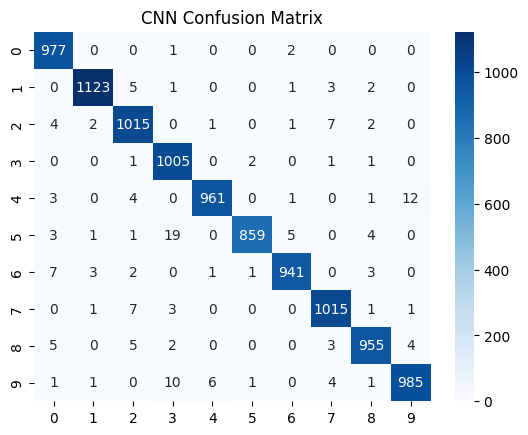

In [13]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(1, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(32*14*14, 128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()
    def forward(self, x):
        x = self.pool(self.relu(self.conv(x)))
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        return self.fc2(x)

cnn = SimpleCNN().to(device)
print("Training CNN...")
cnn = train_model(cnn, train_loader, EPOCHS_CNN)
acc_cnn, f1_cnn, cm_cnn, _, _ = evaluate_model(cnn, test_loader)
print(f"CNN Accuracy: {acc_cnn:.4f}, F1: {f1_cnn:.4f}")
sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Blues')
plt.title("CNN Confusion Matrix")
plt.show()


Pretrained Models (AlexNet, MobileNetV2)

In [14]:
transform_pretrained = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3,1,1)),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

pretrained_ds = datasets.MNIST(MNIST_ROOT, train=False, download=False, transform=transform_pretrained)
pretrained_loader = DataLoader(pretrained_ds, batch_size=BATCH)

def count_params(model):
    return sum(p.numel() for p in model.parameters())

def measure_time(model, loader):
    model.eval(); start = time.time()
    with torch.no_grad():
        for x, _ in loader:
            x = x.to(device)
            _ = model(x)
    return time.time() - start

# AlexNet
alex = models.alexnet(pretrained=True).to(device)
alex.classifier[-1] = nn.Linear(alex.classifier[-1].in_features, 10).to(device)
alex_time = measure_time(alex, pretrained_loader)
print("AlexNet params:", count_params(alex), " | Inference time:", alex_time, "s")

# MobileNetV2
mnet = models.mobilenet_v2(pretrained=True).to(device)
mnet.classifier[-1] = nn.Linear(mnet.classifier[-1].in_features, 10).to(device)
mnet_time = measure_time(mnet, pretrained_loader)
print("MobileNetV2 params:", count_params(mnet), " | Inference time:", mnet_time, "s")


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


100%|██████████| 233M/233M [00:01<00:00, 135MB/s]
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


AlexNet params: 57044810  | Inference time: 13.57208776473999 s
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 151MB/s]


MobileNetV2 params: 2236682  | Inference time: 14.025388717651367 s


Summary

In [15]:
summary = pd.DataFrame([
    {"Model":"MLP (30-20-10)", "Accuracy":acc_mlp, "F1":f1_mlp, "Params":count_params(mlp)},
    {"Model":"Simple CNN", "Accuracy":acc_cnn, "F1":f1_cnn, "Params":count_params(cnn)},
    {"Model":"AlexNet (pretrained)", "Accuracy":"-", "F1":"-", "Params":count_params(alex)},
    {"Model":"MobileNetV2 (pretrained)", "Accuracy":"-", "F1":"-", "Params":count_params(mnet)},
])
summary


,Model,Accuracy,F1,Params
0,MLP (30-20-10),0.9673,0.966998,24380
1,Simple CNN,0.9836,0.983477,804554
2,AlexNet (pretrained),-,-,57044810
3,MobileNetV2 (pretrained),-,-,2236682
